In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-22 13:20:35.343476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list_passed_qc = gene_dict_df.query("qc_pass").dependency_column.tolist()

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list_passed_qc, axis=1)
subset_test_df = test_df.filter(gene_list_passed_qc, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 2862)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.110234,-1.434600,-1.946424,-0.534237,-0.199845,-0.377157,-1.659741,-0.796952,-0.008233,-0.168623,...,-0.035812,-0.161387,-0.266556,-0.974234,-0.171167,-0.019710,-0.085044,0.192152,0.010379,-1.124031
1,-0.251008,-1.132289,-2.355181,-0.341512,-0.684909,-0.890620,-2.454110,-0.957680,-0.007483,0.048342,...,-0.636397,-0.592008,-0.387130,-1.147591,-0.068023,0.265801,-0.746431,-0.427727,-0.894837,-0.292950
2,-0.335133,-1.098382,-2.648633,-0.167452,-0.026155,-0.767525,-2.676043,-1.212208,-0.174508,0.206977,...,-0.236218,-0.619948,-0.410138,-0.811173,-0.133945,0.025385,-0.006648,-0.233497,-0.572335,-0.345550


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 2862)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,-0.063939,-1.300936,-1.994622,-0.251041,-0.201104,-0.754719,-2.412992,-1.143630,0.142893,0.029225,...,-0.578594,-0.387041,-0.289493,-1.318530,-0.324821,-0.019858,-0.449640,-0.081173,-0.545069,-0.197649
1,-0.226252,-1.228556,-2.108228,-0.748439,-0.228569,-0.933119,-2.069771,-0.843195,0.030117,0.124343,...,-0.751705,-0.741778,-0.506887,-1.621673,-0.140264,0.266024,-0.491945,-0.178219,-0.879321,-0.171996
2,-0.248653,-0.834270,-2.157377,-0.446100,-0.209759,-0.743412,-3.341265,-1.050280,0.106808,-0.022087,...,-0.441283,-0.355330,-0.446184,-1.938661,-0.172867,0.007039,-0.201611,-0.096178,-0.889710,-0.149779


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=56,
    batch_size=112,
    encoder_batch_norm=True,
    epochs=305, 
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-22 13:20:42.112690: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/305
7/7 [==============================] - 2s 129ms/step - loss: 2231.7012 - recon: 2204.0129 - kl: 27.6884 - val_loss: 33158.9961 - val_recon: 29188.4746 - val_kl: 3970.5210
Epoch 2/305
7/7 [==============================] - 1s 96ms/step - loss: 1266.1771 - recon: 1238.8759 - kl: 27.3013 - val_loss: 63147.2539 - val_recon: 56912.4688 - val_kl: 6234.7881
Epoch 3/305
7/7 [==============================] - 1s 117ms/step - loss: 856.8808 - recon: 828.6569 - kl: 28.2238 - val_loss: 111444.1016 - val_recon: 102711.6016 - val_kl: 8732.5049
Epoch 4/305
7/7 [==============================] - 1s 106ms/step - loss: 690.8265 - recon: 662.4304 - kl: 28.3961 - val_loss: 27624.4961 - val_recon: 24372.1797 - val_kl: 3252.3176
Epoch 5/305
7/7 [==============================] - 1s 99ms/step - loss: 641.1324 - recon: 612.7715 - kl: 28.3609 - val_loss: 11750.6182 - val_recon: 10707.7363 - val_kl: 1042.8811
Epoch 6/305
7/7 [==============================] - 1s 122ms/step - loss: 539.9739 - recon: 

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

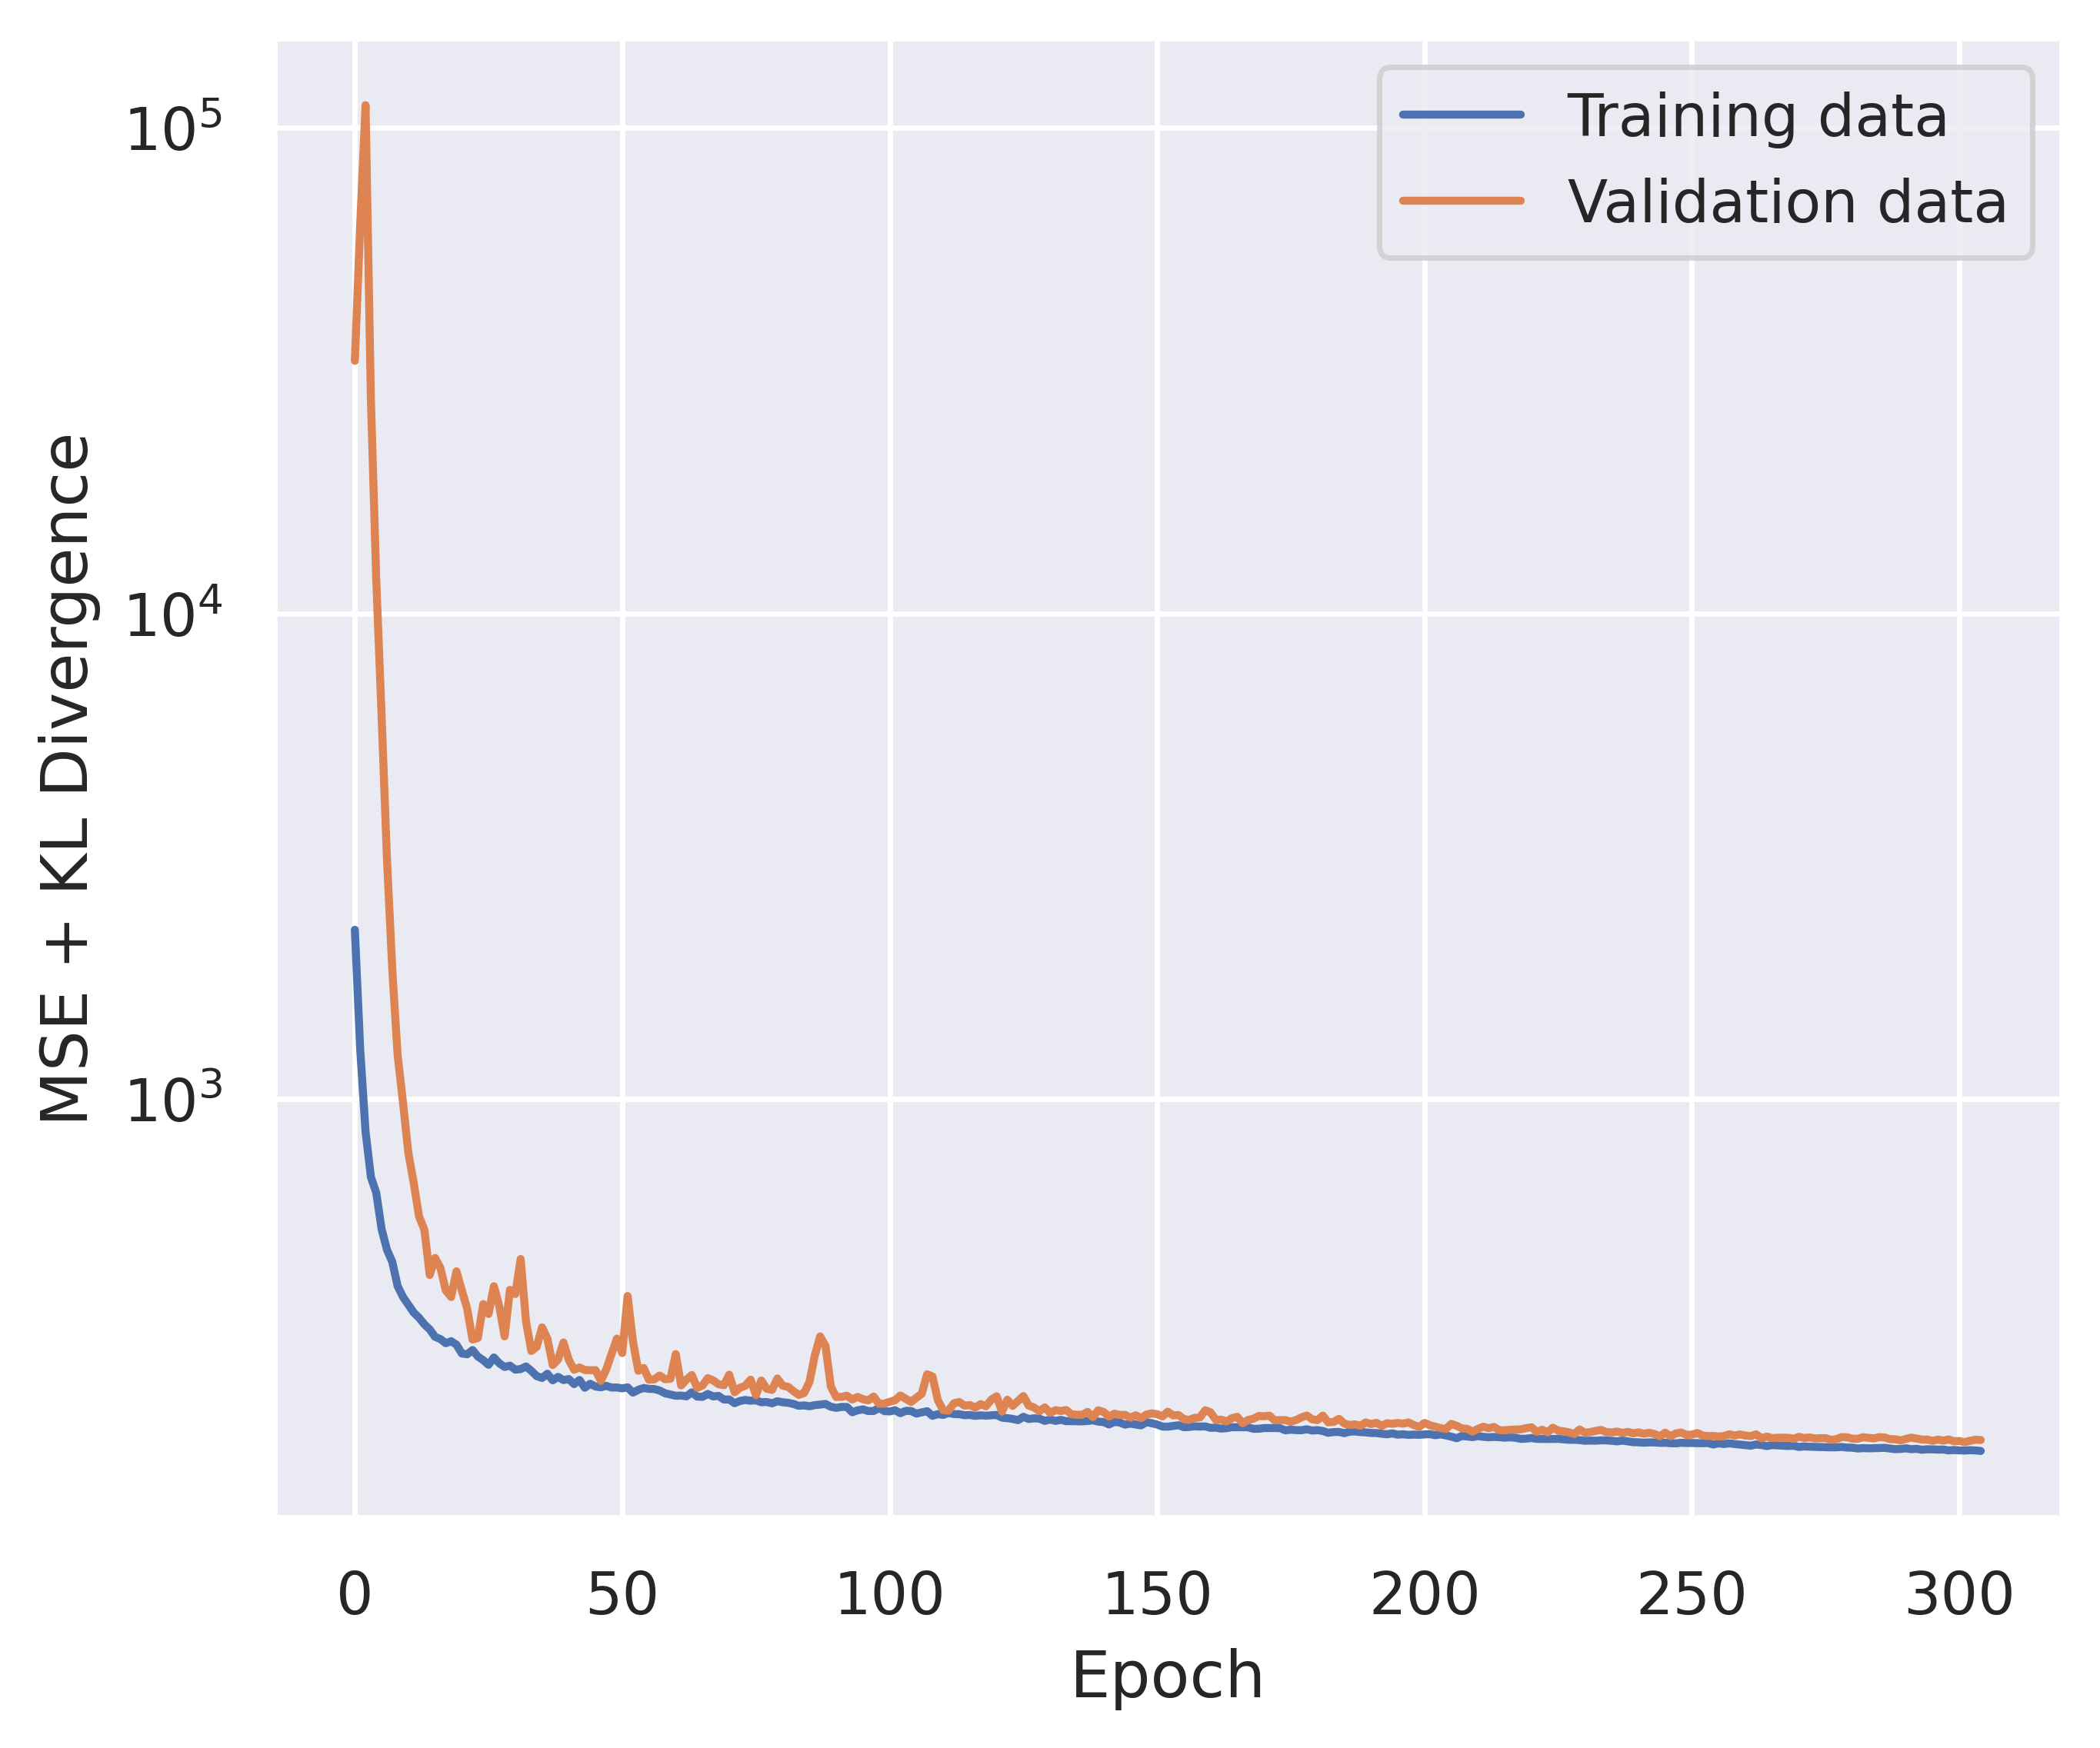

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list_passed_qc, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001820,Adult,Female,train
1,ACH-000632,Adult,Male,train
2,ACH-000403,Adult,Male,train
3,ACH-002233,Adult,Female,train
4,ACH-001852,Adult,Male,train
...,...,...,...,...
907,ACH-000900,Adult,Male,test
908,ACH-001129,Adult,Male,test
909,ACH-000665,Adult,Male,test
910,ACH-000405,Adult,Male,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 1s 34ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,46,47,48,49,50,51,52,53,54,55
0,ACH-001820,0.033012,2.454029,-0.200020,-0.930952,-0.105004,0.066286,0.656221,-0.513948,2.329023,...,-1.201740,1.520554,1.236150,0.914869,-0.434785,1.888903,1.786871,-0.593740,2.349837,1.024181
1,ACH-000632,1.335897,1.458422,-0.402413,-0.666326,1.150006,0.578801,-0.016531,1.435949,-0.926741,...,0.760013,0.551972,-0.731740,-1.325295,0.648749,-0.337791,2.334729,0.019244,-0.128537,0.805020
2,ACH-000403,0.285806,1.196845,2.347686,1.470275,1.040130,0.043655,0.606085,2.100534,1.584386,...,1.336702,0.405433,-0.276691,2.301311,0.185295,0.255464,0.933351,4.069458,0.387041,0.155446
3,ACH-002233,0.129747,1.317303,0.584817,0.780637,-0.552675,-1.319666,2.078983,-1.364332,0.892158,...,-0.315825,0.561363,0.062464,1.544613,1.967639,2.207677,3.532746,0.508986,2.050455,-0.261173
4,ACH-001852,0.374337,0.349337,-0.473771,0.542943,-0.099260,-1.154139,1.227572,0.580085,2.088321,...,-0.342426,0.238972,1.536716,0.699604,-1.039683,-0.179338,1.853832,0.490723,0.999574,1.191672


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.003621,-0.030539,0.005803,-0.053523,0.081258,-0.061141,0.009467,0.041177,0.024255,-0.051101,...,-0.007620,0.076311,0.004459,0.019866,0.018265,-0.008330,-0.084591,0.024035,-0.018626,-0.028110
1,-0.035204,0.054120,-0.016583,0.031840,0.053772,0.043985,-0.038978,-0.041584,-0.049981,-0.060264,...,-0.047986,0.009264,0.037031,-0.020135,-0.069784,-0.042692,0.044006,-0.066479,-0.041929,-0.131357
2,-0.008716,0.055790,-0.016234,0.026713,-0.026491,-0.031592,-0.039716,-0.002119,-0.030370,-0.003438,...,-0.037923,-0.049077,0.005198,-0.036426,-0.009239,-0.044510,-0.032881,-0.018756,-0.040605,-0.014352
3,-0.043036,-0.002256,-0.010101,-0.002127,-0.058436,-0.019942,0.002100,-0.025927,0.040344,0.002491,...,-0.012966,0.009157,-0.002929,-0.037093,0.019743,-0.057616,-0.114067,-0.041586,0.000354,-0.008621
4,-0.044866,0.018422,-0.017908,-0.000651,-0.004964,-0.053290,-0.014199,0.063176,-0.040644,0.106292,...,-0.000491,-0.096097,-0.030075,-0.004071,-0.036055,0.027727,0.022332,-0.125409,-0.000867,-0.022037


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,AAAS,0.003621,-0.030539,0.005803,-0.053523,0.081258,-0.061141,0.009467,0.041177,0.024255,...,-0.007620,0.076311,0.004459,0.019866,0.018265,-0.008330,-0.084591,0.024035,-0.018626,-0.028110
1,AAMP,-0.035204,0.054120,-0.016583,0.031840,0.053772,0.043985,-0.038978,-0.041584,-0.049981,...,-0.047986,0.009264,0.037031,-0.020135,-0.069784,-0.042692,0.044006,-0.066479,-0.041929,-0.131357
2,AARS1,-0.008716,0.055790,-0.016234,0.026713,-0.026491,-0.031592,-0.039716,-0.002119,-0.030370,...,-0.037923,-0.049077,0.005198,-0.036426,-0.009239,-0.044510,-0.032881,-0.018756,-0.040605,-0.014352
3,AARS2,-0.043036,-0.002256,-0.010101,-0.002127,-0.058436,-0.019942,0.002100,-0.025927,0.040344,...,-0.012966,0.009157,-0.002929,-0.037093,0.019743,-0.057616,-0.114067,-0.041586,0.000354,-0.008621
4,AASDHPPT,-0.044866,0.018422,-0.017908,-0.000651,-0.004964,-0.053290,-0.014199,0.063176,-0.040644,...,-0.000491,-0.096097,-0.030075,-0.004071,-0.036055,0.027727,0.022332,-0.125409,-0.000867,-0.022037
